In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Display the first few rows of the dataset and the data types of each column
print(data.head())
print(data.dtypes)


                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2010-01-04  84.750000  85.169998  84.709999  85.080002  72.314575  258800
2010-01-05  83.169998  83.900002  83.010002  83.769997  71.201126  466000
2010-01-06  84.349998  85.070000  84.199997  84.839996  72.110573  390000
2010-01-07  83.110001  83.839996  83.110001  83.790001  71.218124  377700
2010-01-08  84.500000  85.889999  84.500000  85.760002  72.892555  351900
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


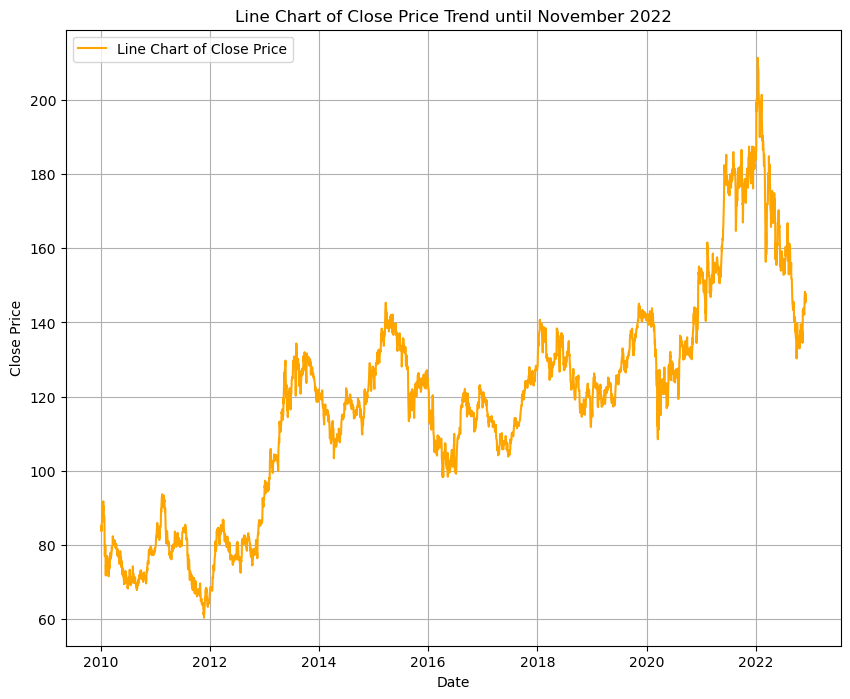

In [15]:
# Filter the data to show from start till "30-11-22"
filtered_data = data[:'2022-11-30']

# Plotting the filtered data as a line chart
plt.figure(figsize=(10, 8))
plt.plot(filtered_data['Close'], label='Line Chart of Close Price', color='orange')
plt.title('Line Chart of Close Price Trend until November 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# LSTM Model

In [23]:
# Scaling the data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the training and validation data for LSTM
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # Include the last 60 days of training data for context

# Create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to be suitable for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Predicting 1 value

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=90, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/90


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0220 - val_loss: 0.0016
Epoch 2/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 4.4480e-04 - val_loss: 0.0019
Epoch 3/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 4.5289e-04 - val_loss: 0.0023
Epoch 4/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 4.1717e-04 - val_loss: 0.0015
Epoch 5/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 4.3285e-04 - val_loss: 0.0013
Epoch 6/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 4.2515e-04 - val_loss: 0.0020
Epoch 7/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 3.9429e-04 - val_loss: 0.0022
Epoch 8/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 3.6324e-04 - val_loss: 0.0015
Epoch 9/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.4137e-04 - val_loss: 0.0019
Epoch 10/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.3224e-04 - val_loss: 0.0011
Epoch 11/90
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.7486e-04 - val_loss: 0.0012
Epoch 12/90
80/80 ━━━━━━━━━━━━━━━

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


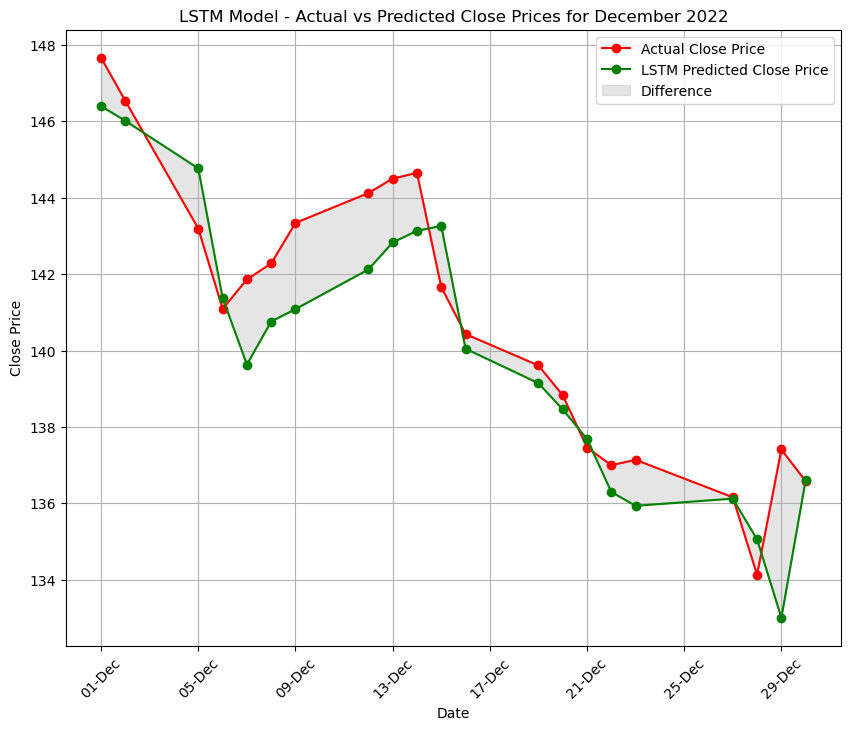

In [25]:
# Make predictions on the test data
predicted_scaled = model.predict(X_test)

# Inverse transform to get the actual values
predicted = scaler.inverse_transform(predicted_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Filter the data for December 2022 only
december_start = '2022-12-01'
december_end = '2022-12-30'
december_mask = (data.index >= december_start) & (data.index <= december_end)

# Filter the actual and predicted values for December 2022
december_dates = data.index[december_mask]
predicted_december = predicted[-len(december_dates):]
y_test_december = y_test_actual[-len(december_dates):]

# Plotting the LSTM predictions vs actual values for December 2022
plt.figure(figsize=(10, 8))
plt.plot(december_dates, y_test_december, label='Actual Close Price', color='red', marker='o')
plt.plot(december_dates, predicted_december, label='LSTM Predicted Close Price', color='green', marker='o')
plt.title('LSTM Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(december_dates, y_test_december.flatten(), predicted_december.flatten(), 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()